# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Train_rev1.zip to Train_rev1.zip


In [0]:
!unzip Train_rev1.zip

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [0]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

188905    We are looking for an experienced Specialist P...
26381     Our international Client is looking for an Ass...
173769    Cathodic Protection Engineer TaxFree salary wi...
Name: FullDescription, dtype: object

In [0]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
27040,67894697,Systems Architect MidLevel,Systems Architect Permanent Farnborough Commu...,Farnborough,Farnborough,NaN,permanent,NaN,Engineering Jobs,32000 - 35000 pa,33500,securityclearedjobs.com,10.419331
209976,72175571,Temporary Community Care Officer / PartTime Mi...,Nottinghamshire County Council For all the fol...,Surrey - Sutton,Sutton Green,part_time,permanent,London4Jobs,Admin Jobs,13475-14446,13960,london4jobs.co.uk,9.544023
238510,72614384,Head of HR Operations – Corporate Functions,Head of HR Operations Corporate Functions Gene...,"Edgware Road, NW1 5DT",St John's Wood,full_time,permanent,Genesis Housing Association,HR & Recruitment Jobs,"c60,000 per annum",60000,peoplemanagement.co.uk,11.002116


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [0]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [0]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
5,13179816,engineering systems analyst water industry,engineering systems analyst water industry loc...,"Dorking, Surrey, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20K to 30K,25000,cv-library.co.uk,10.126671
6,14131336,senior subsea pipeline integrity engineer,a globally renowned engineering and training c...,"Aberdeen, Borders",UK,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,50000 - 100000/annum,75000,cv-library.co.uk,11.225257
7,14663196,recruitment consultant industrial / commercial...,this is a live vacancy not a generic advertise...,"MANCHESTER, Greater Manchester",Manchester,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 26000/annum TO 26K BASIC + COMM + BENS,22000,cv-library.co.uk,9.998843
8,14663197,recruitment consultant construction / technica...,this is an exceptional opportunity to join a c...,"LEEDS, West Yorkshire",Leeds,NaN,permanent,Code Blue Recruitment,HR & Recruitment Jobs,18000 - 28000/annum 18 - 28K BASIC + COMM + BENS,23000,cv-library.co.uk,10.043293
9,15395797,subsea cables engineer,a subsea engineering company is looking for an...,"Aberdeen, UK",Aberdeen,NaN,permanent,Indigo 21 Ltd,Engineering Jobs,70000 - 100000/annum,85000,cv-library.co.uk,11.350418


In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    data[col].apply(lambda row: token_counts.update(row.split()))

In [0]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

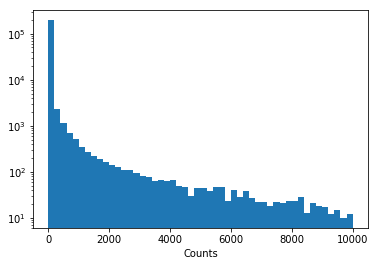

In [0]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = []
for token in token_counts.most_common():
    if token[1] >= min_count:
        tokens.append(token[0])

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [0]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = dict(zip(tokens, [i for i in range(len(tokens))]))

In [0]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [0]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[ 136  114  269    1    1]
 [ 311  236    1    1    1]
 [ 100 4120  135  388   83]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [0]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [0]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  53,  826,   23,  365, 1366,    2,  451,   34,  280,   23],
        [  53,  826,   23,  180,   36,   34,   23, 1705, 7626,  246],
        [  18,   16,   30,  798,    6,  335,    7,  706, 1658,    6]],
       dtype=int32),
 'Log1pSalary': array([10.819798, 10.389026, 10.308986], dtype=float32),
 'Title': array([[ 365, 1366,    2,  451,   34,    1,    1],
        [ 180,   36,   34,   23, 1705, 7626,    1],
        [ 120,   17,  142,  124,  147, 1093,  153]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
!pip install gensim

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1FVoYRyZI_FapGKwga9lhFl-s69XZe4xc'

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

0B7XkCwpI5KDYNlNUTTlSS21pQmM


In [0]:
!ls

 adc.json	     GoogleNews-vectors-negative300.bin   Train_rev1.csv
'edit?usp=sharing'   sample_data			  Train_rev1.zip


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin.gz')

In [0]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [0]:
import gensim
import torch, torch.nn as nn
# weights = torch.FloatTensor(gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True).vectors) 
# I couldn't fit all weights in memory, but then I understood that I don't need every single word from this embedding!
google_embedding = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
emb = nn.Embedding(len(tokens), 300, padding_idx=PAD_IX)
for i, token in enumerate(tokens):
    if token in google_embedding:
        emb.weight.data[i] = torch.FloatTensor(google_embedding[token])

In [0]:
# weights.requires_grad_()

tensor([[ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
         -1.2302e-04, -8.6308e-05],
        [ 7.0312e-02,  8.6914e-02,  8.7891e-02,  ..., -4.7607e-02,
          1.4465e-02, -6.2500e-02],
        [-1.1780e-02, -4.7363e-02,  4.4678e-02,  ...,  7.1289e-02,
         -3.4912e-02,  2.4170e-02],
        ...,
        [-1.9653e-02, -9.0820e-02, -1.9409e-02,  ..., -1.6357e-02,
         -1.3428e-02,  4.6631e-02],
        [ 3.2715e-02, -3.2227e-02,  3.6133e-02,  ..., -8.8501e-03,
          2.6978e-02,  1.9043e-02],
        [ 4.5166e-02, -4.5166e-02, -3.9368e-03,  ...,  7.9590e-02,
          7.2266e-02,  1.3000e-02]], requires_grad=True)

In [0]:
# weights.requires_grad

True

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = emb
        #self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(300, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(300, out_size, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(out_size)
        self.bn2 = nn.BatchNorm1d(out_size)
        self.bn3 = nn.BatchNorm1d(out_size)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = torch.cat([self.bn1(self.conv1(h)).relu(), self.bn2(self.conv2(h)).relu(), self.bn3(self.conv3(h)).relu()], dim=2)
        h = self.pool1(h)
        h = self.dense(h.relu())
        
        return h

In [0]:
title_encoder = TitleEncoder(out_size=128)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 128)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()

        self.emb = emb
        #self.emb = nn.Embedding(n_tokens, 128, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(300, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(300, out_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(300, out_size, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(out_size)
        self.bn2 = nn.BatchNorm1d(out_size)
        self.bn3 = nn.BatchNorm1d(out_size)
        self.pool1 = GlobalMaxPooling()   
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        h = torch.cat([self.bn1(self.conv1(h)).relu(), self.bn2(self.conv2(h)).relu(), self.bn3(self.conv3(h)).relu()], dim=2)
        h = self.pool1(h)
        h = self.dense(h.relu())
        
        return h

In [0]:
desc_encoder = DescEncoder(out_size=128)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 128)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        codesize = 128
       
        self.title_encoder = TitleEncoder(out_size=codesize)
        self.desc_encoder = DescEncoder(out_size=codesize)

        self.categorial_encoder = nn.Sequential(
                                         nn.Linear(n_cat_features, 666),
                                         nn.BatchNorm1d(666),
                                         nn.PReLU(),
                                         nn.Linear(666, codesize)
                                        )
        
        self.combiner = nn.Sequential(
                                    nn.PReLU(),
                                    nn.Linear(128*3, 666),
                                    nn.PReLU(),
                                    #nn.Dropout(),
                                    nn.Linear(666, 1)
                                   )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        categorial_h = self.categorial_encoder(cat_features)
        
        # concatenate all vectors together...
        combined_h = torch.cat([title_h, desc_h, categorial_h], dim=1)
        
        # ... and stack a few more layers at the top
        res = self.combiner(combined_h)[:,0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return res

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    # decided not fix this error
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()
    #return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 150
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [0]:
!pip install livelossplot

In [0]:
from livelossplot import PlotLosses

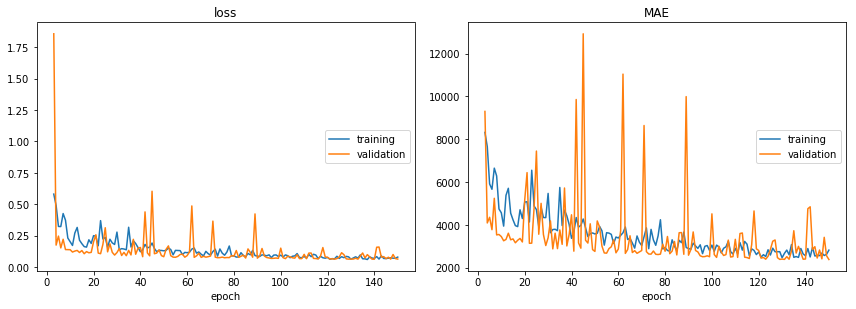

loss:
training   (min:    0.061, max:    3.208, cur:    0.080)
validation (min:    0.063, max:    1.856, cur:    0.064)

MAE:
training   (min: 2466.617, max: 38953.422, cur: 2821.862)
validation (min: 2383.711, max: 14824.082, cur: 2383.711)
Loading best model


FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(34158, 300, padding_idx=1)
    (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(300, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv3): Conv1d(300, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=128, out_features=128, bias=True)
  )
  (desc_encoder): DescEncoder(
    (emb): Embedding(34158, 300, padding_idx=1)
    (conv1): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(300, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv3): Conv1d(300, 128, kernel_size=(7,), stride=(1,), padding=(3,))

In [0]:
liveloss = PlotLosses()
folder = 'p1_model'
valbest = None
try:
    os.makedirs(folder)
except Exception:
    pass
try:
    for epoch_i in range(num_epochs):

        logs = {}
        
        print("Training")
        train_loss = train_mae = train_batches = 0    
        model.train(True)

        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
            reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.cpu().data.numpy()
            train_mae += compute_mae(reference, prediction).cpu().data.numpy()
            train_batches += 1

        logs['loss'] = train_loss.item() / train_batches
        logs['MAE'] = train_mae.item() / train_batches

        
        print("Validation")
        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
            reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1


        logs['val_loss'] = val_loss.item() / val_batches
        logs['val_MAE'] = val_mae.item() / val_batches


        liveloss.update(logs)
        liveloss.draw()

        if valbest is None:
            valbest = logs['val_loss']
            torch.save(model.state_dict(), folder)
        else:
            if logs['val_loss'] < valbest:
                valbest = logs['val_loss']
                torch.save(model.state_dict(), folder)
                               
except KeyboardInterrupt as e:
    print("Early stopping")
    
print("Loading best model")
model = FullNetwork().to(device)
model.load_state_dict(torch.load(folder))
model.eval()                             

In [0]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
    reference = torch.tensor(batch[target_column], dtype=torch.float32).to(device)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy()
    val_mae += compute_mae(reference, prediction).cpu().data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:



	Loss:	0.06329
	MAE:	2407.83787





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    model.to('cpu')
    model.eval()
    
    tokens = sample[col_name].split()
    sample = pd.DataFrame(sample).T
    batch = generate_batch(sample, max_len=max_len)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    
    # compute model prediction on sample (scalar float log-salary)
    baseline_pred = float(model(title_ix, desc_ix, cat_features))
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    
    def replace_ix_f(where, what):
        where[where==what] = UNK_IX
        return where
    
    if col_name=='Title':
        predictions_without_word = [float(model(replace_ix_f(title_ix, x), desc_ix, cat_features)) for x in torch.unique(title_ix)]
    
    if col_name=='FullDescription':
        predictions_without_word = [float(model(title_ix, replace_ix_f(desc_ix, x), cat_features)) for x in torch.unique(desc_ix)]
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    return list(zip(tokens, score_differences))
    

In [0]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             68541169
Title                                                 digital artworker
FullDescription       this is an excellent opportunity to join a lea...
LocationRaw                                              West Yorkshire
LocationNormalized                                       West Yorkshire
ContractType                                                  full_time
ContractTime                                                  permanent
Company                                                           Other
Category                               PR, Advertising & Marketing Jobs
SalaryRaw                                       20000 - 25000 per annum
SalaryNormalized                                                  22500
SourceName                                          jobs.guardian.co.uk
Log1pSalary                                                     10.0213
Name: 45177, dtype: object
[('digital', -0.04459381103515

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [0]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

model.to('cpu')
model.eval()

# predict salary on sample
batch = generate_batch(pd.DataFrame(sample).T, max_len=max_len)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
with torch.no_grad():
    print("Salary (gbp):", float(model(title_ix, desc_ix, cat_features)))

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 208637
Salary (gbp): 9.948729515075684


psv mechanic london

psv mechanic london immediate vacancy for an experienced psv mechanic in the london area . the right psv mechanic must have experience of working on fleets of buses and coaches . the role will involve carrying out the inspection , repair and maintenance of a fleet of single and double deck buses . experience with diagnostics is preferable but not essential , as too is a psv /

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.


1. I think that at this moment the model is not so bad (2700 MAE on validation). However, let's try some things.
2. Let's try to make our model look more serious. Let's add more %s modules.
    1. Dropouts everywhere. ==> it seems like I've added too much of them. Model is hard to train and I see score degradation.
    2. Let's keep dropout only in the end (for classifier). ==> still 2700
    3. Let's add some BatchNorms. ==> ok, it seems like this also doesn't work...
    4. Dropout removing ==> 2631. Let's return to dropout later.
    5. Ok, more layers? More layers. But first let's go to point 3.
3. Let's add livelossplot for convenience and early stopping on KeyboardInterrupt exception (E). ==> With current structure achieved 2475 MAE on validation
4. Now let's again move to A.
    1. Let's add more layers... I've added three concatenated convolutions of different size, let's see what we'll get ==> 2526 MAE on validation
    2. But I forgot to add nonlinearities... ==> 2501. Still the same basically
5. For me it seems like we need to improve embedding (C), these model structure changes are not so important.
    1. Before trying some external embedding. Let's try to switch from 64 to 128 starting from embedding layer. ==> 2486, but still it can be random noise. Let's run it again to check it ==> 2454, even better. Let's try to increase the number of epochs to 150 ==> 2308.
    2. So, now let's change the embedding. I loaded google news embedding, filtered tokens, and started learning. ==> the starting point is better than for the vanilla torch embedding, but further training is not so stable, after 150 epochs the best mae is ~2400